In [1]:
import csv
import sys
import os
import random, shutil
import zipfile
import time
from copy import deepcopy
import torch
import torchaudio
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as tt
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
from tqdm.notebook import tqdm 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display as ipd
from sklearn.model_selection import train_test_split

In [2]:
import opendatasets as od

def download(link):
    direccion = link.split("/")[-1]
    if os.path.isdir(direccion):
        print("Already Exists !")
    return od.download(link)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

Using device: cuda



In [4]:
dataset_ravdess = 'https://www.kaggle.com/uwrfkaggler/ravdess-emotional-speech-audio'
download(dataset_ravdess)

Already Exists !
Skipping, found downloaded files in ".\ravdess-emotional-speech-audio" (use force=True to force download)


In [5]:
dataset_crema = 'https://www.kaggle.com/ejlok1/cremad'
download(dataset_crema)

Already Exists !
Skipping, found downloaded files in ".\cremad" (use force=True to force download)


In [6]:
dataset_surrey = 'https://www.kaggle.com/ejlok1/surrey-audiovisual-expressed-emotion-savee'
download(dataset_surrey)

Already Exists !
Skipping, found downloaded files in ".\surrey-audiovisual-expressed-emotion-savee" (use force=True to force download)


In [7]:
dataset_toronto = 'https://www.kaggle.com/ejlok1/toronto-emotional-speech-set-tess'
download(dataset_toronto)

Already Exists !
Skipping, found downloaded files in ".\toronto-emotional-speech-set-tess" (use force=True to force download)


# Cargamos las localizaciones de nuestros datos

In [8]:
ravdess = 'ravdess-emotional-speech-audio/'
crema = 'cremad/AudioWAV/'
surrey = 'surrey-audiovisual-expressed-emotion-savee/ALL/'
tess = 'toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/'

In [9]:
ravdess_dir = [dir for dir in os.listdir(ravdess) if dir.startswith('Actor_')]
crema_dir = os.listdir(crema)
surrey_dir = os.listdir(surrey)
tess_dir = [dir for dir in os.listdir(tess) if (dir.startswith('OAF_') or dir.startswith('YAF_'))]

In [10]:
def Ravdess():
    emociones = []
    ruta_archivo = []

    for dir in ravdess_dir:
        #os nos deja ir entre direcctorios
        actor = os.listdir(ravdess + dir)
        for file in actor:
            #Usamos .split para separar el nombre del audio en una lista
            delimitacion = file.split('.')[0] #En la primera lista solo queremos el primer elemento, ya que
            #el segundo elemento siempre es wav
            #El primer elemento de la lista se obtinene como 03-01-08-02-02-01-09
            #Donde:
            #03 es el modalidad puede tomar 3 valores (01 = full-AV, 02 = video-only, 03 = audio-only).
            #01 es canal vocal con dos valores (01 = discurso, 02 = cancion).
            #En este caso siempre sera discurso
            #08 es la emocion 
            #(01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
            #02 es la intensidad de la emocion (01 = normal, 02 = strong)
            #Cabe aclarar que para neutral no hay intensidad
            #02 representa la frase que solo hay dos (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
            #01 es la repetición (01 = 1st repetition, 02 = 2nd repetition).
            #09 en el numero de actor tenemos 24 actores, es decir, 24 voces
            delimitacion = delimitacion.split('-') #Hacemos una lista con los elementos del primer elemento de la lista anterior
            #los elementos seran los numeros antes mencionados que daria ['03', '01', '08', '02', '02', '01', '09']
            emociones.append(int(delimitacion[2])) #usando la emocion (en entero) agregandola a una lista de vacia
            ruta_archivo.append(ravdess + dir + '/' + file) #agrgamos el nombre del audio y de la base que viene en una lista vacia
        
    emocion_data = pd.DataFrame(emociones, columns=['Emociones']) #definimos un dataframe con las emociones
    ruta_data = pd.DataFrame(ruta_archivo, columns=['Ruta']) #definimos un dataframe con las rutas
    Ravdess_df = pd.concat([emocion_data, ruta_data], axis=1) #juntamos ambos datframes en uno solo
    Ravdess_df.Emociones.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
    return Ravdess_df

In [11]:
def Crema():
    emociones = []
    ruta_archivo = []
    for file in crema_dir:
        #En DREMA-D (Crowd Sourced Emotional Multimodal Actors Dataset)
        #Tenemos algo mas intuitivo los archivos seran 1001_IEO_ANG_LO.wav 
        #Desconocemos que representa 1001 e IEO, pero suponemos que es la persona y su etnia
        #Esta base tiene mas etnias y nos marca despues del tercer guion bajo la emocion
        # Anger (ANG) Disgust (DIS) Fear (FEA) Happy/Joy (HAP) Neutral (NEU) Sad (SAD)
        #LO es el nivel de emocion (LO = low, MD = medium, HI = high, XX = Unspecified)
        ruta_archivo.append(crema + file) #guardamos la ruta en una lista vacia y de donde viene
        delimitacion = file.split('_') #Hacemos una lsiat con el nombre del archivo
        #Solo toamremos en cuenta la emocion por lo cual las clasificamos y guardamos en una lista vacia
        if delimitacion[2] == 'SAD':
            emociones.append('sad')
        elif delimitacion[2] == 'ANG':
            emociones.append('angry')
        elif delimitacion[2] == 'DIS':
            emociones.append('disgust')
        elif delimitacion[2] == 'FEA':
            emociones.append('fear')
        elif delimitacion[2] == 'HAP':
            emociones.append('happy')
        elif delimitacion[2] == 'NEU':
            emociones.append('neutral')
        else:
            emociones.append('Unknown')
        
    emocion_data = pd.DataFrame(emociones, columns=['Emociones']) #definimos un dataframe con las emociones
    ruta_data = pd.DataFrame(ruta_archivo, columns=['Ruta']) #definimos un dataframe con las rutas
    Crema_df = pd.concat([emocion_data, ruta_data], axis=1) #juntamos ambos datframes en uno solo
    return Crema_df    

In [12]:
def Surrey():
    emociones = []
    ruta_archivo = []
    for file in surrey_dir:
        ruta_archivo.append(surrey + file)
        delimitacion = file.split('_')[1] #hacemos una lista y nos quedamos con el segundo elemento
        #Ya que dividimos por los guin bajos el primer elemento de la lista
        #representa uno de los 4 hablantes nativos de la base
        #en el segundo elemento se representa por stringnumber.wav
        #el string es la emocion (a=angry, d = disgust, f = fear, h = happy, n = neutral, sa = sad, su = surprise)
        #el number solo es le numero de grabacion de la persona
        #Nos enfocamos como siempre en la emocion
        emocion = delimitacion[:1] #el segundo elemento nos da el string
        if emocion == 'a':
            emociones.append('angry')
        elif emocion == 'd':
            emociones.append('disgust')
        elif emocion == 'f':
            emociones.append('fear')
        elif emocion == 'h':
            emociones.append('happy')
        elif emocion == 'n':
            emociones.append('neutral')
        elif emocion == 'sa':
            emociones.append('sad')
        else:
            emociones.append('surprise')
        
    emocion_data = pd.DataFrame(emociones, columns=['Emociones']) #definimos un dataframe con las emociones
    ruta_data = pd.DataFrame(ruta_archivo, columns=['Ruta']) #definimos un dataframe con las rutas
    Surrey_df = pd.concat([emocion_data, ruta_data], axis=1) #juntamos ambos datframes en uno solo
    return Surrey_df    

In [13]:
def Tess():
    emociones = []
    ruta_archivo = []
    for dir in tess_dir:
        #Para esta base tenemos OAF_emotion y YAF_emotion
        #Donde OAF es un hablante de la tercera edad y YAF es un hablante joven
        #emotion es la emocion donde ya tenemos organizadas como las conocemos 
        #neutral, calm, happy, sad, angry, fear, disgust
        #con excepcion de surprice que esta como ps
        hablante = os.listdir(tess + dir)
        for file in hablante:
            delimitacion = file.split('.')[0]
            delimitacion = delimitacion.split('_')[2]
            if delimitacion == 'ps':
                emociones.append('surprise')
            else:
                emociones.append(delimitacion)
            ruta_archivo.append(tess + dir + '/' + file)
    
    emocion_data = pd.DataFrame(emociones, columns=['Emociones']) #definimos un dataframe con las emociones
    ruta_data = pd.DataFrame(ruta_archivo, columns=['Ruta']) #definimos un dataframe con las rutas
    Tess_df = pd.concat([emocion_data, ruta_data], axis=1) #juntamos ambos datframes en uno solo
    return Tess_df

In [14]:
#Para finalizar juntamos todos los datasframes
datos = pd.concat([Ravdess(), Crema(), Surrey(), Tess()], axis = 0)

In [15]:
data = datos
data.to_csv("data_path.csv",index=False)
data.head()

,Emociones,Ruta
0,neutral,ravdess-emotional-speech-audio/Actor_01/03-01-...
1,neutral,ravdess-emotional-speech-audio/Actor_01/03-01-...
2,neutral,ravdess-emotional-speech-audio/Actor_01/03-01-...
3,neutral,ravdess-emotional-speech-audio/Actor_01/03-01-...
4,calm,ravdess-emotional-speech-audio/Actor_01/03-01-...


# Vemos como estan nuestros datos

C:\Users\noble\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


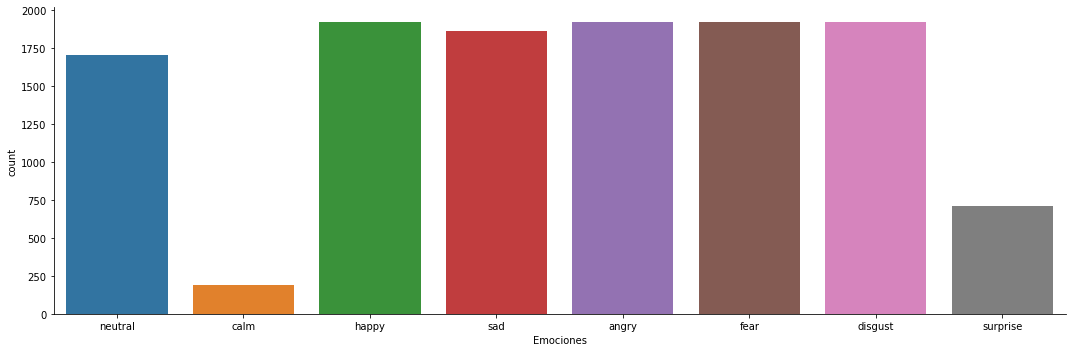

In [16]:
sns.catplot('Emociones',data=datos,kind="count", aspect=3)

**Hacemos un array con las rutas**

Así podremos escoger un elemento aleatorio y lo podremos escuchar.

In [17]:
audios = np.array(datos.Ruta)
sample_path = random.choice(audios)
sample_path

'cremad/AudioWAV/1026_TSI_NEU_XX.wav'

In [18]:
import IPython.display as display
display.Audio(sample_path)

y: [4.2871600e-03 4.4021066e-03 3.8751806e-03 ... 8.8227857e-08 1.4859546e-07
 0.0000000e+00] 

y shape: (58859,) 

Sample rate (KHz): 22050 

Length of audio: 2.669342403628118


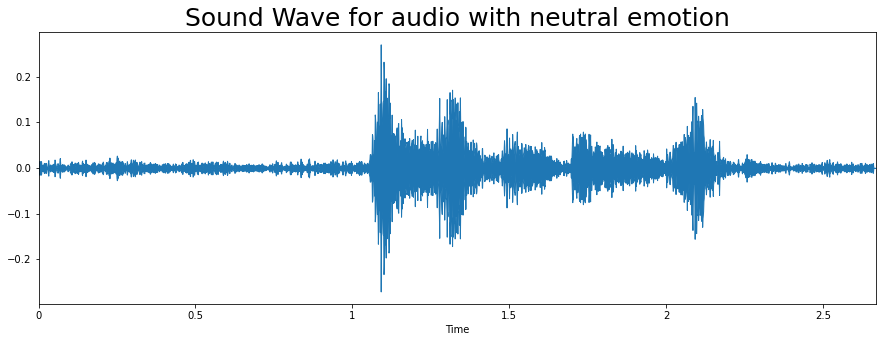

In [19]:
y, sample_rate = librosa.load(sample_path)

print('y:', y, '\n')
print('y shape:', np.shape(y), '\n')
print('Sample rate (KHz):', sample_rate, '\n')
print(f'Length of audio: {np.shape(y)[0]/sample_rate}')
emotion = np.array(datos.Emociones[datos.Ruta == sample_path])[0]
plt.figure(figsize=(15, 5))
librosa.display.waveplot(y=y, sr=sample_rate);
plt.title('Sound Wave for audio with {} emotion'.format(emotion), size=25)
plt.show()

Shape of D object: (1025, 115)


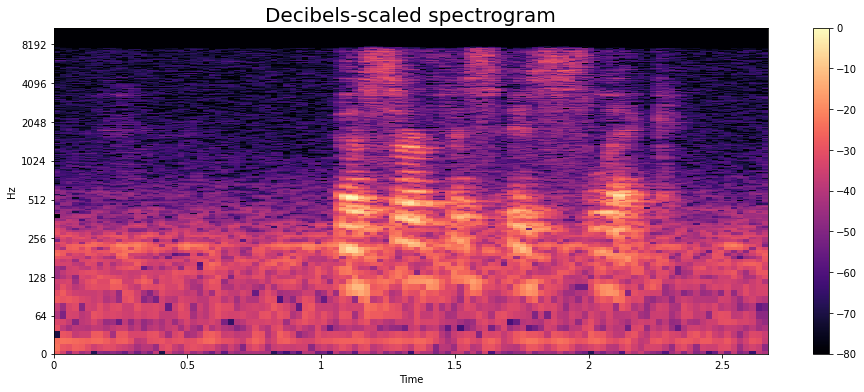

In [20]:
D = np.abs(librosa.stft(y, n_fft=2048, hop_length=512))
print('Shape of D object:', np.shape(D))

DB = librosa.amplitude_to_db(D, ref = np.max)

plt.figure(figsize = (16, 6))
librosa.display.specshow(DB, sr=sample_rate, hop_length=512,
                         x_axis='time', y_axis='log')
plt.colorbar()
plt.title('Decibels-scaled spectrogram', fontsize=20)
plt.show()

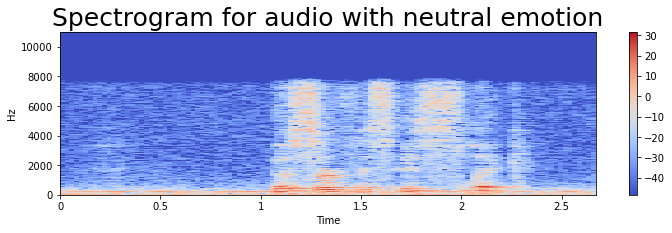

In [21]:
X = librosa.stft(y)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(12, 3))
plt.title('Spectrogram for audio with {} emotion'.format(emotion), size=25)
librosa.display.specshow(Xdb, sr=sample_rate, x_axis='time', y_axis='hz')
plt.colorbar()

In [22]:
from pathlib import Path
def create_spectrogram(filename,name,emotion):
    plt.interactive(False)
    clip, sample_rate = librosa.load(filename, sr=None)
    fig = plt.figure(figsize=[0.72,0.72])
    ax = fig.add_subplot(111)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_frame_on(False)
    S = librosa.feature.melspectrogram(y=clip, sr=sample_rate)
    librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
    PATH = emotion
    Path(PATH).mkdir(parents=True, exist_ok=True)
    im = Path(PATH +name+ '.png')
    plt.savefig(im, dpi=400, bbox_inches='tight',pad_inches=0)
    plt.close()    
    fig.clf()
    plt.close(fig)
    plt.close('all')
    del filename,name,clip,sample_rate,fig,ax,S

In [23]:
dir_spectrograms = "Emotions/"
folders = ['Emotions/neutral/', 'Emotions/calm/', 'Emotions/happy/', 
          'Emotions/sad/', 'Emotions/angry/', 'Emotions/fear/', 'Emotions/disgust/', 'Emotions/surprise/']

In [24]:
#j = 0
#for i in range(8):
    #emotion = folders[i].split('/')[1].split('.')[0]
    #emociones = datos.loc[datos['Emociones']==emotion]
    #audios = np.array(emociones.Ruta)
    #r = len(audios)
    #for file in audios[j:j+r]:
        #filename,name = file,file.split('/')[-1].split('.')[0]
        #create_spectrogram(filename,name,folders[i])

In [25]:
# Pasamos a tensores
import torchvision.datasets as datasets
from torchvision.datasets import ImageFolder
from torchvision import transforms

my_transform = transforms.Compose([transforms.Resize((224,224))
                                       ,transforms.ToTensor()
                                       ,transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                      ])

In [26]:
dataset = ImageFolder(dir_spectrograms, transform=my_transform)

In [27]:
from sklearn.model_selection import train_test_split
train_indices, val_indices = train_test_split(list(range(len(dataset.targets))), test_size=0.3, stratify=dataset.targets)
train_data = torch.utils.data.Subset(dataset, train_indices)
val_data = torch.utils.data.Subset(dataset, val_indices)

In [28]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_data,batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data,batch_size=128, shuffle=True)

In [29]:
import torchvision.models as models
net = models.alexnet()
print(net)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [30]:
net.classifier = nn.Sequential(
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=9216,out_features=384*6*6,bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=384*6*6,out_features=4096,bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096,out_features=4096,bias=True),
    nn.ReLU(inplace=True),
    nn.Linear(in_features=4096,out_features=8,bias=True)
)

In [31]:
net = net.to(device)

In [32]:
for param in net.features.parameters(): param.requires_grad = False

if torch.cuda.is_available():
    net = net.cuda()

print(net)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=13824, bias=True)


In [33]:
from torch import optim
optimizer = optim.SGD(net.classifier.parameters(),lr=0.1,momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [34]:
def fit(model, dataloader, optimizer, criterion, pbar, train=True):
    running_loss = 0.0
    correct, total = 0,0
    for i, (features, targets) in enumerate(dataloader, 0):
        features = features.to(device) # Por si hay gpu
        targets = targets.to(device) # Por si hay gpu
        logits = model(features)
        _, predicted_labels = torch.max(logits,1)
    
        total += targets.size(0)
        correct += (predicted_labels == targets).sum() 
        loss = criterion(logits, targets)

        running_loss += loss.item()
        avg_loss = running_loss/(i + 1)
        acc = correct.float()/total
        
        pbar.set_postfix(avg_loss='{:.4f}'.format(avg_loss), acc='{:.4f}'.format(acc))
        pbar.update(targets.shape[0])
    return avg_loss, acc

In [35]:
def train(model, train_loader, val_loader, optimizer, criterion, epochs):
    train_time = 0
    epoch_loss = list(); epoch_acc = list()
    val_loss = list(); val_acc = list()
    
    n_train = len(train_loader.dataset)
    n_val = len(val_loader.dataset)
    model.train() # -> aplica drop si lo tiene el modelo y lleva registro de los gradientes
    for epoch in range(epochs):
        start_time = time.time()
        with tqdm(total=n_train, position=0) as pbar_train:
            pbar_train.set_description(f'Epoch {epoch + 1}/'+str(epochs)+' - train')
            pbar_train.set_postfix(avg_loss='0.0', acc='0.0')
            loss_train, acc_train = fit(model, train_loader, optimizer, criterion, pbar_train)
            train_time +=  time.time() - start_time
        model.eval() # -> de esta forma no incluye dropout, ni lleva registro de los gradientes
        with tqdm(total=n_val, position=0) as pbar_val:
            pbar_val.set_description(f'Epoch {epoch + 1}/'+str(epochs)+' - val')
            pbar_val.set_postfix(avg_loss='0.0', acc='0.0')
            loss_val, acc_val = fit(model, val_loader, optimizer, criterion, pbar_val, train=False)

    epoch_loss.append(loss_train)
    epoch_acc.append(acc_train)

    val_loss.append(loss_val)
    val_acc.append(acc_val)

    return epoch_loss, epoch_acc, val_loss, val_acc, train_time

In [36]:
epochs = 100
epoch_loss, epoch_acc, val_loss, val_acc, train_time = train(net, train_loader, val_loader, optimizer, criterion, epochs)
print("\n --- %s seconds ---", train_time)

  0%|          | 0/8513 [00:00<?, ?it/s]

  0%|          | 0/3649 [00:00<?, ?it/s]

  0%|          | 0/8513 [00:00<?, ?it/s]

  0%|          | 0/3649 [00:00<?, ?it/s]

  0%|          | 0/8513 [00:00<?, ?it/s]

  0%|          | 0/3649 [00:00<?, ?it/s]

  0%|          | 0/8513 [00:00<?, ?it/s]

  0%|          | 0/3649 [00:00<?, ?it/s]

  0%|          | 0/8513 [00:00<?, ?it/s]

  0%|          | 0/3649 [00:00<?, ?it/s]

  0%|          | 0/8513 [00:00<?, ?it/s]

  0%|          | 0/3649 [00:00<?, ?it/s]

  0%|          | 0/8513 [00:00<?, ?it/s]

  0%|          | 0/3649 [00:00<?, ?it/s]

  0%|          | 0/8513 [00:00<?, ?it/s]

  0%|          | 0/3649 [00:00<?, ?it/s]

  0%|          | 0/8513 [00:00<?, ?it/s]

  0%|          | 0/3649 [00:00<?, ?it/s]

  0%|          | 0/8513 [00:00<?, ?it/s]

  0%|          | 0/3649 [00:00<?, ?it/s]

  0%|          | 0/8513 [00:00<?, ?it/s]

  0%|          | 0/3649 [00:00<?, ?it/s]

  0%|          | 0/8513 [00:00<?, ?it/s]

  0%|          | 0/3649 [00:00<?, ?it/s]

  0%|          | 0/8513 [00:00<?, ?it/s]

  0%|          | 0/3649 [00:00<?, ?it/s]

  0%|          | 0/8513 [00:00<?, ?it/s]

  0%|          | 0/3649 [00:00<?, ?it/s]

  0%|          | 0/8513 [00:00<?, ?it/s]

  0%|          | 0/3649 [00:00<?, ?it/s]

  0%|          | 0/8513 [00:00<?, ?it/s]

  0%|          | 0/3649 [00:00<?, ?it/s]

  0%|          | 0/8513 [00:00<?, ?it/s]

  0%|          | 0/3649 [00:00<?, ?it/s]

  0%|          | 0/8513 [00:00<?, ?it/s]

  0%|          | 0/3649 [00:00<?, ?it/s]

  0%|          | 0/8513 [00:00<?, ?it/s]

  0%|          | 0/3649 [00:00<?, ?it/s]

  0%|          | 0/8513 [00:00<?, ?it/s]

  0%|          | 0/3649 [00:00<?, ?it/s]

  0%|          | 0/8513 [00:00<?, ?it/s]

  0%|          | 0/3649 [00:00<?, ?it/s]

  0%|          | 0/8513 [00:00<?, ?it/s]

  0%|          | 0/3649 [00:00<?, ?it/s]

  0%|          | 0/8513 [00:00<?, ?it/s]

  0%|          | 0/3649 [00:00<?, ?it/s]

  0%|          | 0/8513 [00:00<?, ?it/s]

  0%|          | 0/3649 [00:00<?, ?it/s]

  0%|          | 0/8513 [00:00<?, ?it/s]

  0%|          | 0/3649 [00:00<?, ?it/s]

  0%|          | 0/8513 [00:00<?, ?it/s]

  0%|          | 0/3649 [00:00<?, ?it/s]

  0%|          | 0/8513 [00:00<?, ?it/s]

  0%|          | 0/3649 [00:00<?, ?it/s]

  0%|          | 0/8513 [00:00<?, ?it/s]

  0%|          | 0/3649 [00:00<?, ?it/s]

  0%|          | 0/8513 [00:00<?, ?it/s]

  0%|          | 0/3649 [00:00<?, ?it/s]

  0%|          | 0/8513 [00:00<?, ?it/s]

  0%|          | 0/3649 [00:00<?, ?it/s]

  0%|          | 0/8513 [00:00<?, ?it/s]

  0%|          | 0/3649 [00:00<?, ?it/s]

  0%|          | 0/8513 [00:00<?, ?it/s]

  0%|          | 0/3649 [00:00<?, ?it/s]

  0%|          | 0/8513 [00:00<?, ?it/s]

  0%|          | 0/3649 [00:00<?, ?it/s]

  0%|          | 0/8513 [00:00<?, ?it/s]

  0%|          | 0/3649 [00:00<?, ?it/s]

  0%|          | 0/8513 [00:00<?, ?it/s]

  0%|          | 0/3649 [00:00<?, ?it/s]

  0%|          | 0/8513 [00:00<?, ?it/s]

  0%|          | 0/3649 [00:00<?, ?it/s]

  0%|          | 0/8513 [00:00<?, ?it/s]

  0%|          | 0/3649 [00:00<?, ?it/s]

  0%|          | 0/8513 [00:00<?, ?it/s]

  0%|          | 0/3649 [00:00<?, ?it/s]

  0%|          | 0/8513 [00:00<?, ?it/s]

  0%|          | 0/3649 [00:00<?, ?it/s]

  0%|          | 0/8513 [00:00<?, ?it/s]

  0%|          | 0/3649 [00:00<?, ?it/s]

  0%|          | 0/8513 [00:00<?, ?it/s]

  0%|          | 0/3649 [00:00<?, ?it/s]

  0%|          | 0/8513 [00:00<?, ?it/s]

  0%|          | 0/3649 [00:00<?, ?it/s]

  0%|          | 0/8513 [00:00<?, ?it/s]

  0%|          | 0/3649 [00:00<?, ?it/s]

  0%|          | 0/8513 [00:00<?, ?it/s]

  0%|          | 0/3649 [00:00<?, ?it/s]

  0%|          | 0/8513 [00:00<?, ?it/s]

  0%|          | 0/3649 [00:00<?, ?it/s]

  0%|          | 0/8513 [00:00<?, ?it/s]

  0%|          | 0/3649 [00:00<?, ?it/s]

  0%|          | 0/8513 [00:00<?, ?it/s]

  0%|          | 0/3649 [00:00<?, ?it/s]

  0%|          | 0/8513 [00:00<?, ?it/s]

  0%|          | 0/3649 [00:00<?, ?it/s]

  0%|          | 0/8513 [00:00<?, ?it/s]

  0%|          | 0/3649 [00:00<?, ?it/s]

  0%|          | 0/8513 [00:00<?, ?it/s]

  0%|          | 0/3649 [00:00<?, ?it/s]

  0%|          | 0/8513 [00:00<?, ?it/s]

  0%|          | 0/3649 [00:00<?, ?it/s]

  0%|          | 0/8513 [00:00<?, ?it/s]

  0%|          | 0/3649 [00:00<?, ?it/s]

  0%|          | 0/8513 [00:00<?, ?it/s]

  0%|          | 0/3649 [00:00<?, ?it/s]

  0%|          | 0/8513 [00:00<?, ?it/s]

  0%|          | 0/3649 [00:00<?, ?it/s]

  0%|          | 0/8513 [00:00<?, ?it/s]

  0%|          | 0/3649 [00:00<?, ?it/s]

  0%|          | 0/8513 [00:00<?, ?it/s]

  0%|          | 0/3649 [00:00<?, ?it/s]

  0%|          | 0/8513 [00:00<?, ?it/s]

  0%|          | 0/3649 [00:00<?, ?it/s]

  0%|          | 0/8513 [00:00<?, ?it/s]

  0%|          | 0/3649 [00:00<?, ?it/s]

  0%|          | 0/8513 [00:00<?, ?it/s]

  0%|          | 0/3649 [00:00<?, ?it/s]

  0%|          | 0/8513 [00:00<?, ?it/s]

  0%|          | 0/3649 [00:00<?, ?it/s]

  0%|          | 0/8513 [00:00<?, ?it/s]

  0%|          | 0/3649 [00:00<?, ?it/s]

  0%|          | 0/8513 [00:00<?, ?it/s]

  0%|          | 0/3649 [00:00<?, ?it/s]

  0%|          | 0/8513 [00:00<?, ?it/s]

  0%|          | 0/3649 [00:00<?, ?it/s]

  0%|          | 0/8513 [00:00<?, ?it/s]

  0%|          | 0/3649 [00:00<?, ?it/s]

  0%|          | 0/8513 [00:00<?, ?it/s]

  0%|          | 0/3649 [00:00<?, ?it/s]

  0%|          | 0/8513 [00:00<?, ?it/s]

  0%|          | 0/3649 [00:00<?, ?it/s]

  0%|          | 0/8513 [00:00<?, ?it/s]

  0%|          | 0/3649 [00:00<?, ?it/s]

  0%|          | 0/8513 [00:00<?, ?it/s]

  0%|          | 0/3649 [00:00<?, ?it/s]

  0%|          | 0/8513 [00:00<?, ?it/s]

  0%|          | 0/3649 [00:00<?, ?it/s]

  0%|          | 0/8513 [00:00<?, ?it/s]

  0%|          | 0/3649 [00:00<?, ?it/s]

  0%|          | 0/8513 [00:00<?, ?it/s]

  0%|          | 0/3649 [00:00<?, ?it/s]

  0%|          | 0/8513 [00:00<?, ?it/s]

  0%|          | 0/3649 [00:00<?, ?it/s]

  0%|          | 0/8513 [00:00<?, ?it/s]

  0%|          | 0/3649 [00:00<?, ?it/s]

  0%|          | 0/8513 [00:00<?, ?it/s]

  0%|          | 0/3649 [00:00<?, ?it/s]

  0%|          | 0/8513 [00:00<?, ?it/s]

  0%|          | 0/3649 [00:00<?, ?it/s]

  0%|          | 0/8513 [00:00<?, ?it/s]

  0%|          | 0/3649 [00:00<?, ?it/s]

  0%|          | 0/8513 [00:00<?, ?it/s]

  0%|          | 0/3649 [00:00<?, ?it/s]

  0%|          | 0/8513 [00:00<?, ?it/s]

  0%|          | 0/3649 [00:00<?, ?it/s]

  0%|          | 0/8513 [00:00<?, ?it/s]

  0%|          | 0/3649 [00:00<?, ?it/s]

  0%|          | 0/8513 [00:00<?, ?it/s]

  0%|          | 0/3649 [00:00<?, ?it/s]

  0%|          | 0/8513 [00:00<?, ?it/s]

  0%|          | 0/3649 [00:00<?, ?it/s]

  0%|          | 0/8513 [00:00<?, ?it/s]

  0%|          | 0/3649 [00:00<?, ?it/s]

  0%|          | 0/8513 [00:00<?, ?it/s]

  0%|          | 0/3649 [00:00<?, ?it/s]

  0%|          | 0/8513 [00:00<?, ?it/s]

  0%|          | 0/3649 [00:00<?, ?it/s]

  0%|          | 0/8513 [00:00<?, ?it/s]

  0%|          | 0/3649 [00:00<?, ?it/s]

  0%|          | 0/8513 [00:00<?, ?it/s]

  0%|          | 0/3649 [00:00<?, ?it/s]

  0%|          | 0/8513 [00:00<?, ?it/s]

  0%|          | 0/3649 [00:00<?, ?it/s]

  0%|          | 0/8513 [00:00<?, ?it/s]

  0%|          | 0/3649 [00:00<?, ?it/s]

  0%|          | 0/8513 [00:00<?, ?it/s]

  0%|          | 0/3649 [00:00<?, ?it/s]

  0%|          | 0/8513 [00:00<?, ?it/s]

  0%|          | 0/3649 [00:00<?, ?it/s]

  0%|          | 0/8513 [00:00<?, ?it/s]

  0%|          | 0/3649 [00:00<?, ?it/s]

  0%|          | 0/8513 [00:00<?, ?it/s]

  0%|          | 0/3649 [00:00<?, ?it/s]

  0%|          | 0/8513 [00:00<?, ?it/s]

  0%|          | 0/3649 [00:00<?, ?it/s]

  0%|          | 0/8513 [00:00<?, ?it/s]

  0%|          | 0/3649 [00:00<?, ?it/s]

  0%|          | 0/8513 [00:00<?, ?it/s]

  0%|          | 0/3649 [00:00<?, ?it/s]

  0%|          | 0/8513 [00:00<?, ?it/s]

  0%|          | 0/3649 [00:00<?, ?it/s]

  0%|          | 0/8513 [00:00<?, ?it/s]

  0%|          | 0/3649 [00:00<?, ?it/s]

  0%|          | 0/8513 [00:00<?, ?it/s]

  0%|          | 0/3649 [00:00<?, ?it/s]

  0%|          | 0/8513 [00:00<?, ?it/s]

  0%|          | 0/3649 [00:00<?, ?it/s]

  0%|          | 0/8513 [00:00<?, ?it/s]

  0%|          | 0/3649 [00:00<?, ?it/s]


 --- %s seconds --- 2955.034403562546


In [37]:
#epoch_acc_cpu = [0]
#val_acc_cpu = [0]
#epoch_acc_cpu[0] = epoch_acc[0].cpu()
#val_acc_cpu[0] = val_acc[0].cpu()

In [38]:
#Veamos la presicion
correct = 0
total = 0
with torch.no_grad():
    for data in train_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Presicion de la red: %d %%' % (100 * correct / total))

Presicion de la red: 15 %


In [39]:
classes = ('neutral', 'calm', 'happy', 
          'sad', 'angry', 'fear', 'disgust', 'surprise')
class_correct = list(0. for i in range(8))
class_total = list(0. for i in range(8))
with torch.no_grad():
    for data in train_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
if class_total[i] == 0.0:
    class_total[i] = 100
for i in range(8):
    print('Presicion de %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))


Presicion de neutral :  0 %
Presicion de  calm :  0 %
Presicion de happy :  0 %
Presicion de   sad :  0 %
Presicion de angry :  0 %
Presicion de  fear :  0 %
Presicion de disgust : 100 %
Presicion de surprise :  0 %


In [40]:
import torchvision.models as models
model=models.resnet18()
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [41]:
for param in model.parameters():
    param.requires_grad = False
    
model.fc = nn.Linear(512, 8)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [45]:
epochs = 50
steps = 0
running_loss = 0
print_every = 20
train_losses, val_losses = [], []
for epoch in range(epochs):
    for inputs, labels in train_loader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if steps % print_every == 0:
            val_loss = 0
            accuracy = 0
            accuracy_val = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    val_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy_val += torch.mean(equals.type(torch.FloatTensor)).item()
            model.eval()
            with torch.no_grad():
                for inputs, labels in train_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    val_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss/len(train_loader))
            val_losses.append(val_loss/len(val_loader))                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train accuracy: {accuracy/len(train_loader):.3f}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Val accuracy: {accuracy_val/len(val_loader):.3f}.. "
                  f"Val loss: {val_loss/len(val_loader):.3f}")
            running_loss = 0
            model.train()

Epoch 1/50.. Train accuracy: 0.158.. Train loss: -50.325.. Val accuracy: 0.159.. Val loss: -190.689
Epoch 1/50.. Train accuracy: 0.177.. Train loss: -94.809.. Val accuracy: 0.177.. Val loss: -312.759
Epoch 1/50.. Train accuracy: 0.158.. Train loss: -122.507.. Val accuracy: 0.157.. Val loss: -439.790
Epoch 2/50.. Train accuracy: 0.158.. Train loss: -150.321.. Val accuracy: 0.159.. Val loss: -542.199
Epoch 2/50.. Train accuracy: 0.158.. Train loss: -177.801.. Val accuracy: 0.157.. Val loss: -634.315
Epoch 2/50.. Train accuracy: 0.158.. Train loss: -204.502.. Val accuracy: 0.157.. Val loss: -723.223
Epoch 3/50.. Train accuracy: 0.158.. Train loss: -230.812.. Val accuracy: 0.159.. Val loss: -813.551
Epoch 3/50.. Train accuracy: 0.158.. Train loss: -256.677.. Val accuracy: 0.159.. Val loss: -895.454
Epoch 3/50.. Train accuracy: 0.158.. Train loss: -282.585.. Val accuracy: 0.157.. Val loss: -977.851
Epoch 3/50.. Train accuracy: 0.158.. Train loss: -308.449.. Val accuracy: 0.158.. Val loss: -

Epoch 25/50.. Train accuracy: 0.158.. Train loss: -2032.733.. Val accuracy: 0.158.. Val loss: -6777.223
Epoch 25/50.. Train accuracy: 0.158.. Train loss: -2058.514.. Val accuracy: 0.158.. Val loss: -6844.017
Epoch 25/50.. Train accuracy: 0.158.. Train loss: -2077.952.. Val accuracy: 0.157.. Val loss: -6953.805
Epoch 26/50.. Train accuracy: 0.158.. Train loss: -2106.336.. Val accuracy: 0.159.. Val loss: -7017.298
Epoch 26/50.. Train accuracy: 0.158.. Train loss: -2128.988.. Val accuracy: 0.159.. Val loss: -7094.645
Epoch 26/50.. Train accuracy: 0.158.. Train loss: -2152.406.. Val accuracy: 0.158.. Val loss: -7207.370
Epoch 26/50.. Train accuracy: 0.158.. Train loss: -2176.520.. Val accuracy: 0.158.. Val loss: -7248.031
Epoch 27/50.. Train accuracy: 0.158.. Train loss: -2201.783.. Val accuracy: 0.157.. Val loss: -7304.072
Epoch 27/50.. Train accuracy: 0.158.. Train loss: -2224.411.. Val accuracy: 0.158.. Val loss: -7427.579
Epoch 27/50.. Train accuracy: 0.159.. Train loss: -2250.772.. Va

Epoch 48/50.. Train accuracy: 0.158.. Train loss: -3926.425.. Val accuracy: 0.159.. Val loss: -13030.293
Epoch 49/50.. Train accuracy: 0.159.. Train loss: -3951.274.. Val accuracy: 0.157.. Val loss: -13114.772
Epoch 49/50.. Train accuracy: 0.158.. Train loss: -3974.821.. Val accuracy: 0.158.. Val loss: -13193.678
Epoch 49/50.. Train accuracy: 0.158.. Train loss: -3998.024.. Val accuracy: 0.158.. Val loss: -13281.231
Epoch 49/50.. Train accuracy: 0.158.. Train loss: -4018.039.. Val accuracy: 0.158.. Val loss: -13424.664
Epoch 50/50.. Train accuracy: 0.158.. Train loss: -4048.759.. Val accuracy: 0.157.. Val loss: -13480.463
Epoch 50/50.. Train accuracy: 0.158.. Train loss: -4069.489.. Val accuracy: 0.157.. Val loss: -13534.024
Epoch 50/50.. Train accuracy: 0.159.. Train loss: -4090.960.. Val accuracy: 0.160.. Val loss: -13577.537


In [46]:
def create_new_spectrogram(filename,name,emotion):
    plt.interactive(False)
    clip, sample_rate = librosa.load(filename, sr=None)
    fig = plt.figure(figsize=[0.73,0.73])
    plt.rcParams["figure.autolayout"] = True
    plt.axis('off')
    S = librosa.feature.melspectrogram(y=sig, sr=fs)
    librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
    PATH = emotion
    Path(PATH).mkdir(parents=True, exist_ok=True)
    im = Path(PATH +name+ '.png')
    plt.savefig(im, dpi=400, bbox_inches='tight',pad_inches=0)
    plt.close()    
    fig.clf()
    plt.close(fig)
    plt.close('all')
    del filename,name,clip,sample_rate,fig,ax,S

In [47]:
dir_new_spectrograms = "spectrograms/"
new_folders = ['spectrograms/neutral/', 'spectrograms/calm/', 'spectrograms/happy/', 
          'spectrograms/sad/', 'spectrograms/angry/', 'spectrograms/fear/', 'spectrograms/disgust/', 'spectrograms/surprise/']

In [ ]:
j = 0
for i in range(8):
    emotion = new_folders[i].split('/')[1].split('.')[0]
    emociones = datos.loc[datos['Emociones']==emotion]
    audios = np.array(emociones.Ruta)
    r = len(audios)
    for file in audios[j:j+r]:
        filename,name = file,file.split('/')[-1].split('.')[0]
        create_new_spectrogram(filename,name,new_folders[i])

In [48]:
class Model(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(Model, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        #Layers
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)   
        self.fc = nn.Linear(hidden_dim, output_size)
    
    def forward(self, x):
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size)
        out, hidden = self.rnn(x, hidden)
        out = out.contiguous().view(-1, self.hidden_dim)
        out = self.fc(out)
        return out, hidden
    
    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        return hidden

In [50]:
RNN = Model(len(train_loader), len(train_loader), hidden_dim=12, n_layers=1)
RNN.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(RNN.parameters(), lr=lr)